# Linear regression

Linear regression is a fundamental technique in statistical modeling for analyzing the relationship between a dependent variable (target) and one or more independent variables (features). Mathematically, it can be expressed as follows:

Given a dataset with $n$ observations and $m$ features, the goal of linear regression is to find the coefficients $w$ and an intercept $b$ that minimize the residual sum of squares (RSS):
$$ RSS(w, b) = Σ_{i=1}^{n} (y_i - (wx_i + b))^2 $$

Here, $y_i$ represents the observed target value for the $i$-th observation, $x_i$ represents the vector of features for the $i$-th observation, and $w$ and $b$ are the coefficients to be determined. The linear regression model assumes a linear relationship between the features and the target:
$$ y_i = wx_i + b + ε_i $$

Where $ε_i$ represents the error term. The coefficients $w$ and $b$ are estimated using various optimization techniques to minimize the RSS, resulting in a linear equation that can predict the target variable based on the input features. Linear regression serves as a foundation for understanding more complex regression techniques and is widely used in various fields for predictive modeling and analysis.

## Imports

In [61]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.cluster import DBSCAN

## Load dataset

This project focuses on predicting medical costs using data science techniques, with a primary emphasis on linear regression. By analyzing a dataset containing features such as age, BMI, and smoking habits, we aim to create a predictive model that estimates medical expenses accurately. 

The medical costs dataset can be found [here](https://www.kaggle.com/datasets/nanditapore/medical-cost-dataset/discussion?resource=download). 

In [62]:
df = pd.read_csv('medical_cost.csv')
df.head()

,Id,age,sex,bmi,children,smoker,region,charges
0,1,19,female,27.900,0,yes,southwest,16884.92400
1,2,18,male,33.770,1,no,southeast,1725.55230
2,3,28,male,33.000,3,no,southeast,4449.46200
3,4,33,male,22.705,0,no,northwest,21984.47061
4,5,32,male,28.880,0,no,northwest,3866.85520


First, we need to convert the categorical values (yes/no, female/male, etc.) to numerical values (1/0 etc.). 

In [63]:
print('Unique values for column \'sex\':', df['sex'].unique())
print('Unique values for column \'smoker\':', df['smoker'].unique())
print('Unique values for column \'region\':', df['region'].unique())

Unique values for column 'sex': ['female' 'male']
Unique values for column 'smoker': ['yes' 'no']
Unique values for column 'region': ['southwest' 'southeast' 'northwest' 'northeast']


The two first features ('sex' and 'smoker') are binary, so we can convert them to 0/1. 
The third ('region') has four values without any oridnal relationship among them, and we therefore use one-hot-encoding. 

In [64]:
df['sex'] = df['sex'].map({'female': 1, 'male': 0})
df['smoker'] = df['smoker'].map({'yes': 1, 'no': 0})
df = pd.get_dummies(df, columns=['region'], prefix=['region'])
df.head()

,Id,age,sex,bmi,children,smoker,charges,region_northeast,region_northwest,region_southeast,region_southwest
0,1,19,1,27.900,0,1,16884.92400,0,0,0,1
1,2,18,0,33.770,1,0,1725.55230,0,0,1,0
2,3,28,0,33.000,3,0,4449.46200,0,0,1,0
3,4,33,0,22.705,0,0,21984.47061,0,1,0,0
4,5,32,0,28.880,0,0,3866.85520,0,1,0,0


Then we create a correlation matrix of all features and the target. 

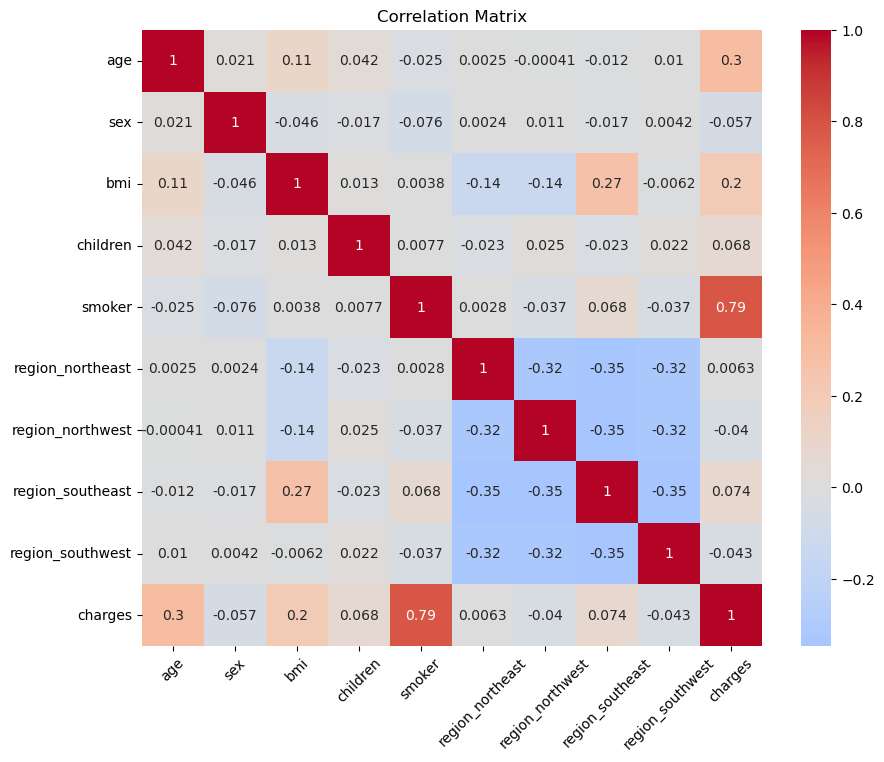

In [65]:
# Select relevant features for correlation analysis
selected_features = ['age', 'sex', 'bmi', 'children', 'smoker', 'region_northeast', 'region_northwest', 'region_southeast', 'region_southwest', 'charges']

# Create a subset of the dataframe with the selected features
subset_df = df[selected_features]

# Calculate the correlation matrix
correlation_matrix = subset_df.corr()

# Set up the figure and axes
plt.figure(figsize=(10, 8))

# Create a heatmap of the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)

# Customize the plot
plt.title('Correlation Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# Show the plot
plt.show()

We want to predict charges, and see that the features 'age', 'bmi', and 'smoker' are its most correlated features. Therefore, we use those three features for our linear regression model. 

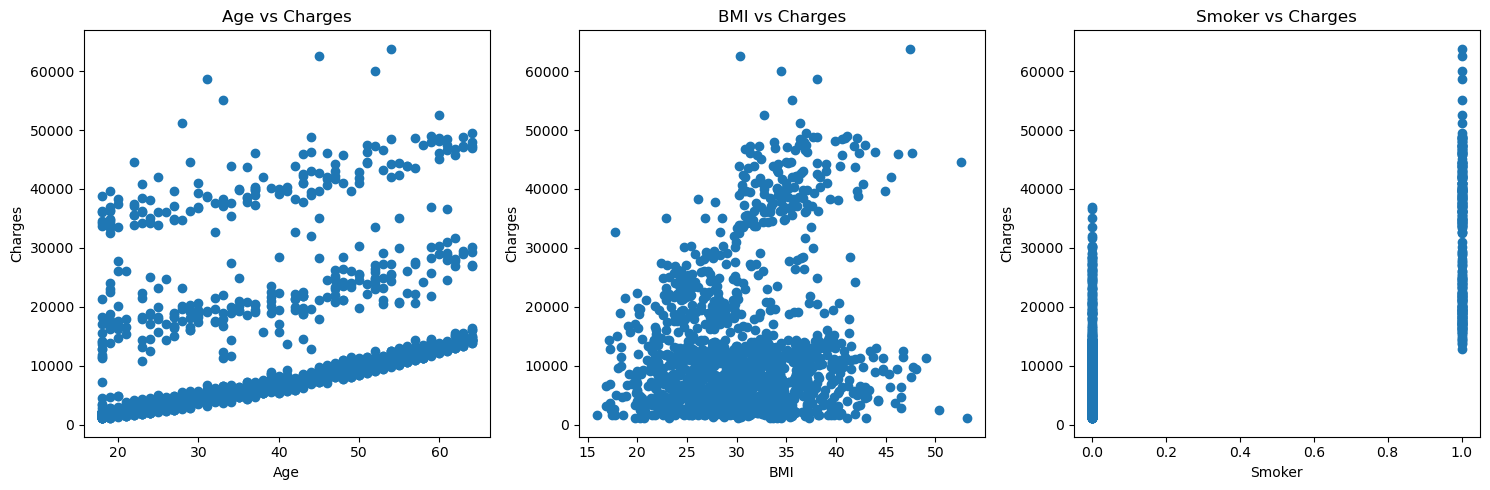

In [66]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Scatterplot for 'age' against 'charges'
axes[0].scatter(df['age'], df['charges'])
axes[0].set_title('Age vs Charges')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Charges')

# Scatterplot for 'bmi' against 'charges'
axes[1].scatter(df['bmi'], df['charges'])
axes[1].set_title('BMI vs Charges')
axes[1].set_xlabel('BMI')
axes[1].set_ylabel('Charges')

# Scatterplot for 'smoker' against 'charges'
axes[2].scatter(df['smoker'], df['charges'])
axes[2].set_title('Smoker vs Charges')
axes[2].set_xlabel('Smoker')
axes[2].set_ylabel('Charges')

plt.tight_layout()
plt.show()

Then, we extract the features (age, bmi, smoker)...

In [67]:
age_features = [feature for feature in df if feature.startswith('age')]
features = [*age_features, 'bmi', 'smoker']
X = df[features]
X.head()

,age,bmi,smoker
0,19,27.900,1
1,18,33.770,0
2,28,33.000,0
3,33,22.705,0
4,32,28.880,0


... and the target (charges) from the dataframe.

In [68]:
y = df['charges']
y.head()

0    16884.92400
1     1725.55230
2     4449.46200
3    21984.47061
4     3866.85520
Name: charges, dtype: float64

Normalizing input features is important in linear regression to ensure that features with different scales do not disproportionately influence the model's coefficients, leading to biased predictions and inaccurate interpretations of feature importance.

In [69]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

Then we split into train and test sets. 

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Model

Now we have the dataset and can initialize the model. Ridge regression is chosen for this problem due to its ability to handle multicollinearity among predictor variables and prevent overfitting by adding a regularization term to the linear regression model, which can enhance the model's generalization performance on predicting medical costs.

The goal of Ridge Regression is to find the coefficients $w$ and an intercept $b$ that minimize the penalized residual sum of squares (RSS) along with the L2 regularization term:
$$
RSS_{Ridge}(w, b) = Σ_{i=1}^{n} (y_i - (wx_i + b))^2 + \alpha Σ_{j=1}^{m} w_j^2
$$

Choosing RidgeCV is advantageous because it automates the process of selecting the optimal regularization parameter (alpha) using cross-validation, ensuring a balance between model complexity and overfitting, ultimately leading to a more robust and accurate prediction model.

In [71]:
alphas = [10**i for i in range(-2, 3)]
ridge_cv = RidgeCV(alphas=alphas, cv=5)

We use k-fold cross validation because it allows for a more robust and reliable assessment of the model's performance by systematically evaluating its predictive ability on multiple subsets of the dataset, reducing the risk of overfitting and providing a better estimate of how the model will perform on unseen data.

In [72]:
cross_val_scores = cross_val_score(ridge_cv, X_train, y_train, cv=5)
print("Cross-validation scores:", cross_val_scores)

Cross-validation scores: [0.71505943 0.80418098 0.72259394 0.65979934 0.76267555]


Fit model to training data using the optimal alpha.

In [73]:
ridge_cv.fit(X_train, y_train)

RidgeCV(alphas=[0.01, 0.1, 1, 10, 100], cv=5)

In [74]:
print("Best alpha determined by cross-validation:", ridge_cv.alpha_)

Best alpha determined by cross-validation: 1.0


... and make predictions. 

In [75]:
y_pred = ridge_cv.predict(X_test)

## Performance

Finally, we can display the performance of the model. First, we evaluate the models using mean squared error defined as

$$ MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 $$

where $n$ is the number of data points, $y_i$ represents the target value for the $i$-th data point, and $\hat{y}_i$ represents the predicted target value for the $i$-th data point. 



In [76]:
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Mean Squared Error: 34517967.935190156


The coefficient of determination, commonly known as R-squared, is a statistical measure that indicates the proportion of the variance in the dependent variable (target) that is predictable from the independent variables (features) in a regression model.
The formula for R-squared is given by:

$$ R^2 = 1 - \frac{SS_{res}}{SS_{tot}} $$

where $SS_{res}$ is the sum of squares of residuals (the sum of squared differences between the actual and predicted values) and $SS_{tot}$ is the total sum of squares (the sum of squared differences between the actual values and the mean of the actual values). 

Specifically, R-squared measures the goodness-of-fit of the model to the actual data points. It ranges between 0 and 1, where:
* An R-squared value of 0 indicates that the model does not explain any of the variability in the target variable.
* An R-squared value of 1 indicates that the model perfectly explains the variability in the target variable.

In [77]:
r2 = r2_score(y_test, y_pred)
print("R-squared:", r2)

R-squared: 0.7776602256037162


Displaying the model coefficients and intercept helps us understand the specific impact of each input feature on the predicted output and provides insight into the baseline prediction when all input features are zero.

In [78]:
print("Coefficients:", ridge_cv.coef_)
print("Intercept:", ridge_cv.intercept_)

Coefficients: [3639.65081273 1988.52725908 9544.94311685]
Intercept: 13321.325882073372


## Residuals

Residual analysis involves examining the patterns and distributions of the model's residuals to ensure the underlying assumptions of linear regression are met and to identify any potential issues with the model's fit.

In [79]:
residuals = y_test - y_pred

* Residuals vs. Fitted Plot: This plot displays the relationship between the predicted values and the residuals. It helps us identify if there is any pattern in the residuals, which could indicate non-linearity or heteroscedasticity in the model.

* Residuals Distribution Plot: This histogram shows the distribution of residuals. By examining the shape and spread of the histogram, we can check whether the residuals are approximately normally distributed.

* Residuals Q-Q Plot: The quantile-quantile (Q-Q) plot compares the distribution of residuals against a theoretical normal distribution. If the points lie close to the diagonal line, it suggests that the residuals follow a normal distribution, which is an assumption of linear regression.

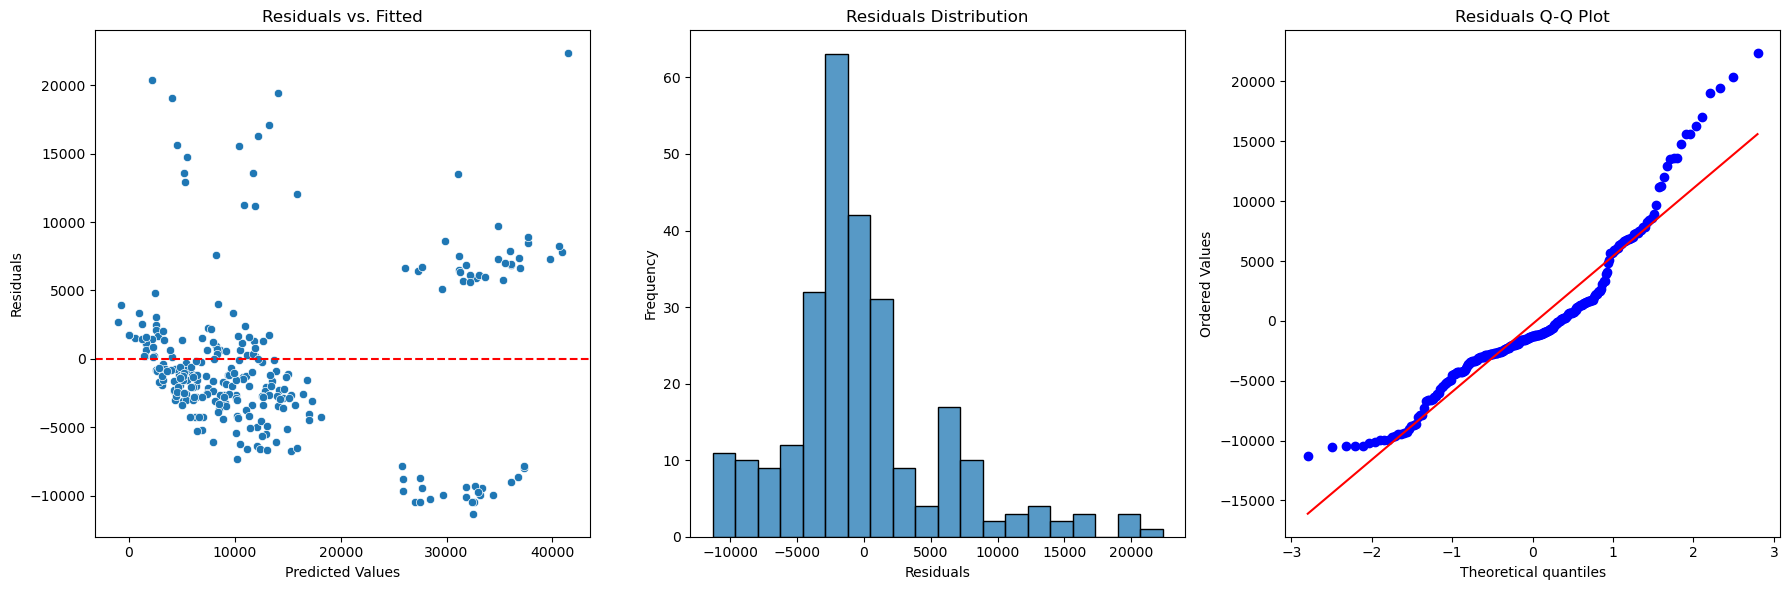

In [80]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='r', linestyle='--')
plt.title('Residuals vs. Fitted')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')

plt.subplot(1, 3, 2)
sns.histplot(residuals, bins=20)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
stats.probplot(residuals, plot=plt)
plt.title('Residuals Q-Q Plot')

plt.tight_layout()
plt.show()

## Outliers

We use DBSCAN for outlier detection because it's effective at identifying outliers in datasets with complex and irregular shapes, where traditional distance-based methods might struggle. DBSCAN's ability to group data points into clusters and label points as noise is particularly useful in scenarios where outliers don't necessarily follow a simple pattern and might be grouped with other points.

In [81]:
dbscan = DBSCAN(eps=0.8, min_samples=5)
outliers = dbscan.fit_predict(X)

Visualize the results

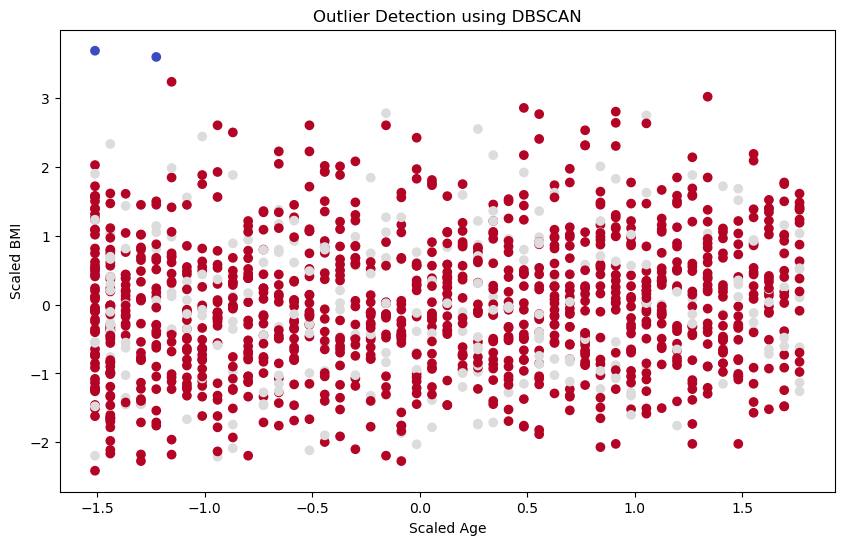

In [82]:
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, -2], c=outliers, cmap='coolwarm', marker='o')
plt.title('Outlier Detection using DBSCAN')
plt.xlabel('Scaled Age')
plt.ylabel('Scaled BMI')
plt.show()